<a href="https://colab.research.google.com/github/VishnuPy/MyPython/blob/master/Spam_Detection_NLP_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive
%ls

Found GPU at: /device:GPU:0
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive
'My Drive'/


In [0]:
import tensorflow as tf
import timeit

# See https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.device('/cpu:0'):
  random_image_cpu = tf.random_normal((100, 100, 100, 3))
  net_cpu = tf.layers.conv2d(random_image_cpu, 32, 7)
  net_cpu = tf.reduce_sum(net_cpu)

with tf.device('/gpu:0'):
  random_image_gpu = tf.random_normal((100, 100, 100, 3))
  net_gpu = tf.layers.conv2d(random_image_gpu, 32, 7)
  net_gpu = tf.reduce_sum(net_gpu)

sess = tf.Session(config=config)

# Test execution once to detect errors early.
try:
  sess.run(tf.global_variables_initializer())
except tf.errors.InvalidArgumentError:
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise

def cpu():
  sess.run(net_cpu)
  
def gpu():
  sess.run(net_gpu)
  
# Runs the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.5289264630000616
GPU (s):
0.19278506199998446
GPU speedup over CPU: 18x


In [0]:
from keras.preprocessing.text import Tokenizer
from keras import models
from keras import layers
from numpy import zeros
from random import shuffle
from random import seed
from matplotlib import pyplot

Using TensorFlow backend.


<font color=brown size=4>
Read the file, separate into two lists, one each for Training and Testing. Turn the lists

In [0]:
def read_lines():
    train_lines = []
    test_lines = []
    current_lines = []

    with open('/gdrive/My Drive/MyLearning/MLDLAIPython/Data/TextData/SpamDetectionData.txt') as f: 
        for line in f.readlines(): 
            if line.startswith('# Test data', 0):
                train_lines = current_lines
                current_lines = test_lines
            elif line.startswith('#', 0):
                '''
                Ignore comment lines
                '''
            elif line == '\n':
                '''
                Ignore empty lines
                '''
            else:
                current_lines.append(line)

    test_lines = current_lines
    
    seed(1337)
    shuffle(train_lines)
    shuffle(test_lines)

    print('Read training lines: ', len(train_lines))
    print('Read test lines: ', len(test_lines))

    return train_lines, test_lines


<font color=brown size=4>
Take a list of lines from Original Input files (train and test), remove paragraph and line breaks and split into label and data by using Comma as divider. Return as two separate lists preserving the sort order.

In [0]:
def split_lines(lines):
    data = []
    labels = []
    maxtokens = 0
    for line in lines:
        label_part, data_part = line.replace('<p>','').replace('</p>','').replace('\n', '').split(',')
        data.append(data_part)
        labels.append(label_part)
        if (len(data_part)>maxtokens):
            maxtokens=len(data_part)

    print('maxlen ', maxtokens)

    return data, labels

<font color=brown size=4>
While processing the data with Keras, each Original text will be converted to a list of indices. These indices point to words in a dictionary of all words contained in the training data. We convert this to a binary matrix. The value 1 in the matrix says that a word (x in the matrix) is contained in a given text (y in the matrix)

In [0]:
def vectorize_sequences(sequences, dimension=4000):
    results = zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

'''
The label vectorization is quite simple:
  the value 1 is for spam,
  the value 0 is for ham
'''
def vectorize_labels(labels):
    results = zeros(len(labels))
    for i, label in enumerate(labels):
        if (label.lower() == 'spam'):
            results[i] = 1
    return results

def test_predict(model, testtext, expected_label):
    testtext_list = []
    testtext_list.append(testtext)
    testtext_sequence = tokenizer.texts_to_sequences(testtext_list)
    x_testtext = vectorize_sequences(testtext_sequence)
    prediction = model.predict(x_testtext)[0][0]
    
    print("Sentiment: %.3f" % prediction, 'Expected ', expected_label)

    if prediction > 0.5:
        if expected_label == 'Spam':
            return True
    else:
        if expected_label == 'Ham':
            return True
    
    return False

def plot_accuracy(history):
    pyplot.plot(history.history['acc'])
    pyplot.plot(history.history['val_acc'])
    pyplot.title('model accuracy')
    pyplot.ylabel('accuracy')
    pyplot.xlabel('epoch')
    pyplot.legend(['training', 'validation'], loc='lower right')
    pyplot.show()

def plot_loss(history):
    pyplot.plot(history.history['loss'])
    pyplot.plot(history.history['val_loss'])
    pyplot.title('model loss')
    pyplot.ylabel('loss')
    pyplot.xlabel('epoch')
    pyplot.legend(['training', 'validation'], loc='upper right')
    pyplot.show()

In [0]:
# Start script

# First split train lines from test lines
train_lines, test_lines = read_lines()

Read training lines:  2000
Read test lines:  100


In [0]:
# Split data from label for each line
train_data_raw, train_labels_raw = split_lines(train_lines)
test_data_raw, test_labels_raw = split_lines(test_lines)

maxlen  3691
maxlen  3244


In [0]:
print (len(train_data_raw))
print (len(train_label_raw))
print (len(test_data_raw))
print (len(test_label_raw))

2000
2000
100
100


<font color=brown size=4>
Use Keras Tokenizer to Vectorize Text. Fit_on_texts will setup internal Vacabulary using all words from the training data and attaching indices to them.
Text_to_sequences will tranform each text into sequence of integer


In [0]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data_raw)
train_data_seq = tokenizer.texts_to_sequences(train_data_raw)
test_data_seq = tokenizer.texts_to_sequences(test_data_raw)

<font color=brown size=4>
# Finally the integer sequenes are converted to a binary (numpy)
# matrix where rows are for the text lines, columns are for
# the words. 1 = word is inside text, 0 = word is not inside

In [0]:
x_train = vectorize_sequences(train_data_seq, 4000)
print('Lines of training data: ', len(x_train))
x_test = vectorize_sequences(test_data_seq, 4000)
print('Lines of test data: ', len(x_test))

Lines of training data:  2000
Lines of test data:  100


<font color=brown size=4>
The labels are also converted to a binary vector
1 Means Spam; 0 Means Ham

In [0]:
y_train = vectorize_labels(train_labels_raw)
print('Lines of training results: ', len(y_train))
y_test = vectorize_labels(test_labels_raw)
print('Lines of test results: ', len(y_test))

Lines of training results:  2000
Lines of test results:  100


<font color=blue size=6>
Now we build the Kera Neural Nets Model



Train on 1400 samples, validate on 600 samples
Epoch 1/8




1400/1400 [==============================] - 0s 351us/step - loss: 0.2236 - acc: 0.9564 - val_loss: 0.0638 - val_acc: 1.0000
Epoch 2/8
1400/1400 [==============================] - 0s 80us/step - loss: 0.0437 - acc: 1.0000 - val_loss: 0.0234 - val_acc: 1.0000
Epoch 3/8
1400/1400 [==============================] - 0s 78us/step - loss: 0.0175 - acc: 1.0000 - val_loss: 0.0107 - val_acc: 1.0000
Epoch 4/8
1400/1400 [==============================] - 0s 71us/step - loss: 0.0081 - acc: 1.0000 - val_loss: 0.0054 - val_acc: 1.0000
Epoch 5/8
1400/1400 [==============================] - 0s 74us/step - loss: 0.0040 - acc: 1.0000 - val_loss: 0.0029 - val_acc: 1.0000
Epoch 6/8
1400/1400 [==============================] - 0s 76us/step - loss: 0.0020 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 7/8
1400/1400 [==============================] - 0s 72us/step - loss: 0.0011 - acc: 1.0000 - val_loss: 9.4588e-04 - val_acc: 1.0000
Epoc

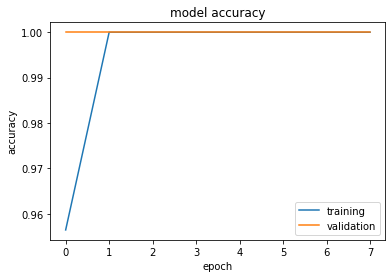

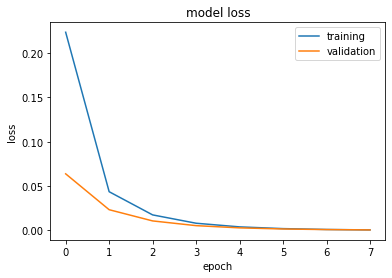

100/100 [==============================] - 0s 162us/step
['loss', 'acc']
Test result:  [3.8596277718170314e-05, 1.0]


In [0]:
# Now we build the Keras model
model = models.Sequential()
model.add(layers.Dense(8, activation='relu', input_shape=(4000,)))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])

# Train the model
history = model.fit(x_train,y_train,epochs=8,batch_size=100,validation_split=0.3)

# summarize history for accuracy
plot_accuracy(history)

# summarize history for loss
plot_loss(history)

# Evaluate the model
results = model.evaluate(x_test, y_test)
print(model.metrics_names)
print('Test result: ', results)

In [0]:
# Manual test over all test records
correct = 0
wrong = 0
for input_text, expected_label in zip(test_data_raw, test_labels_raw):
    if test_predict(model, input_text, expected_label):
        correct = correct + 1
    else:
        wrong = wrong + 1

print('Predictions correct ', correct, ', wrong ', wrong)


Sentiment: 0.000 Expected  Ham
Sentiment: 1.000 Expected  Spam
Sentiment: 0.000 Expected  Ham
Sentiment: 1.000 Expected  Spam
Sentiment: 1.000 Expected  Spam
Sentiment: 1.000 Expected  Spam
Sentiment: 0.000 Expected  Ham
Sentiment: 0.000 Expected  Ham
Sentiment: 0.000 Expected  Ham
Sentiment: 0.000 Expected  Ham
Sentiment: 1.000 Expected  Spam
Sentiment: 1.000 Expected  Spam
Sentiment: 0.000 Expected  Ham
Sentiment: 1.000 Expected  Spam
Sentiment: 1.000 Expected  Spam
Sentiment: 1.000 Expected  Spam
Sentiment: 1.000 Expected  Spam
Sentiment: 1.000 Expected  Spam
Sentiment: 1.000 Expected  Spam
Sentiment: 1.000 Expected  Spam
Sentiment: 0.000 Expected  Ham
Sentiment: 0.000 Expected  Ham
Sentiment: 0.000 Expected  Ham
Sentiment: 0.000 Expected  Ham
Sentiment: 0.000 Expected  Ham
Sentiment: 0.001 Expected  Ham
Sentiment: 0.000 Expected  Ham
Sentiment: 0.000 Expected  Ham
Sentiment: 0.000 Expected  Ham
Sentiment: 1.000 Expected  Spam
Sentiment: 0.000 Expected  Ham
Sentiment: 1.000 Expected

In [0]:
y_train.shape